# 随机森林预测气温 Random Forest Temperature Prediction

## 背景 Background

气温预测的任务目标就是使用一份天气相关数据来预测某一天的最高温度，属于回归任务，其中涉及多个模块，主要包含随机森林建模、特征选择、效率对比、参数调优等

The goal of the temperature prediction task is to use weather-related data to forecast the maximum temperature for a given day. This is a regression task, involving multiple components, primarily including Random Forest modeling, feature selection, efficiency comparison, and parameter tuning.

## 数据分析和预处理 Data Analysis and Preprocessing

查看数据格式、样本分布 

Check Data Format,  Sample Distribution

In [1]:
import pandas as pd;

features = pd.read_csv('data/temps.csv')
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


In [3]:
features.shape

(348, 9)

处理数据 Basic Data Processing

（1）时间格式转换：转换成标准时间格式

（2）特征编码：把字符串转换枚举便于使用

（3）数据重新组合切分

(1) Time Format Conversion: Convert to standard time format

(2) Feature Encoding: Convert strings to enumerations for easier use

(3) Data Resampling and Splitting

In [8]:
import datetime

# 分别得到年，月，日
# Extract the year, month, and day separately
years = features['year']
months = features['month']
days = features['day']

# datetime格式
# Convert the extracted values into datetime format
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) 
         for year, month, day in zip(years, months, days)]

# 将字符串转换为datetime对象
# Convert the string dates into datetime objects
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# 打印前五个日期
# Display the first 5 dates
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

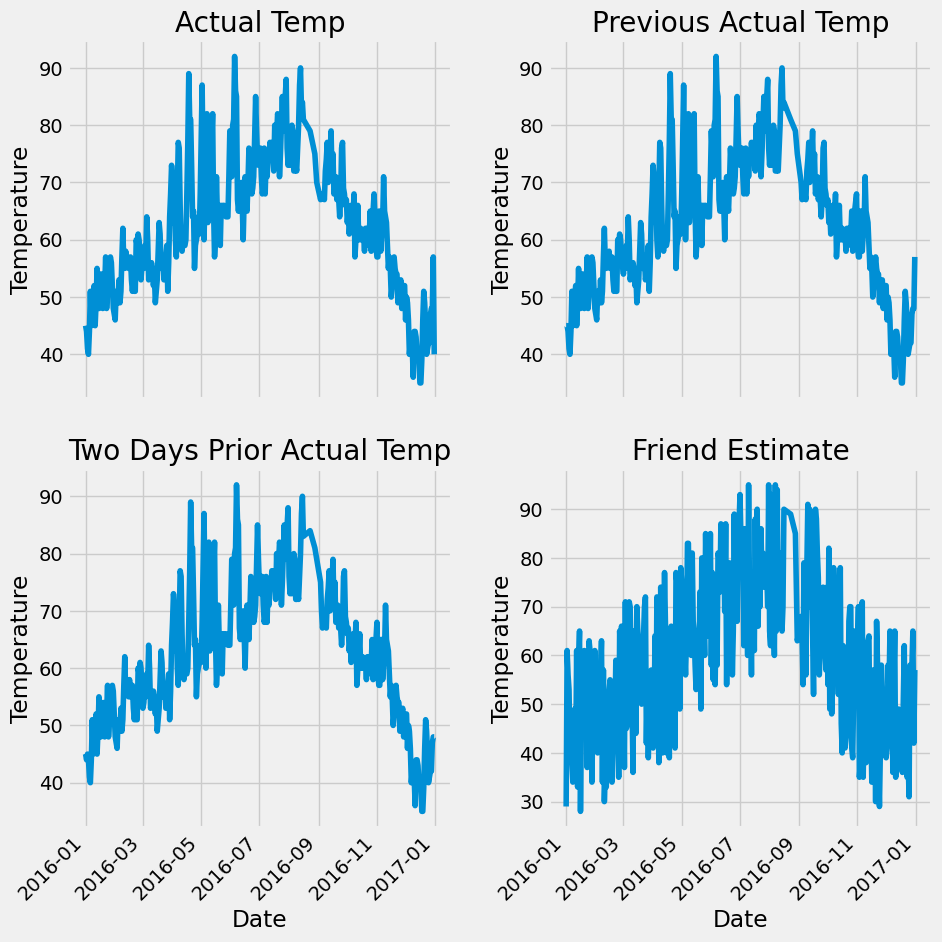

In [9]:
# 准备画图
# Prepare for plotting
import matplotlib.pyplot as plt

# 使绘图内嵌于Notebook中
# Display plots inline (for Jupyter Notebooks)
%matplotlib inline

# 指定默认风格
# Set the default style
plt.style.use('fivethirtyeight')

# 设置布局
# Set up the layout for subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# 自动调整x轴标签的日期格式
# Auto-format the x-axis date labels with a 45-degree rotation
fig.autofmt_xdate(rotation=45)

# 真实值
# Actual temperature
ax1.plot(dates, features['actual'])
ax1.set_xlabel('')  # No label for x-axis
ax1.set_ylabel('Temperature')
ax1.set_title('Actual Temp')

# 昨天
# Temperature from the previous day
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel('')  # No label for x-axis
ax2.set_ylabel('Temperature')
ax2.set_title('Previous Actual Temp')

# 前天
# Temperature from two days ago
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date')
ax3.set_ylabel('Temperature')
ax3.set_title('Two Days Prior Actual Temp')

# 朋友预测
# Friend's temperature estimate
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date')
ax4.set_ylabel('Temperature')
ax4.set_title('Friend Estimate')

# 自动调整子图间距
# Automatically adjust the space between subplots
plt.tight_layout(pad=2)

In [10]:
# 独热编码，把字符串str拆分成了is_str的枚举
# One-hot encode the features, converting string columns into enumerated binary columns
features = pd.get_dummies(features)

# 显示前5行数据
# Display the first 5 rows of the encoded features
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,True,False,False,False,False,False,False
1,2016,1,2,44,45,45.7,44,61,False,False,True,False,False,False,False
2,2016,1,3,45,44,45.8,41,56,False,False,False,True,False,False,False
3,2016,1,4,44,41,45.9,40,53,False,True,False,False,False,False,False
4,2016,1,5,41,40,46.0,44,41,False,False,False,False,False,True,False


In [11]:
# 数据与标签
# Data and labels
import numpy as np

# 标签
# Labels
labels = np.array(features['actual'])

# 在特征中去掉标签
# Remove the labels from the features
features = features.drop('actual', axis=1)

# 名字单独保存一下，以备后患
# Save the feature names separately for future use
feature_list = list(features.columns)

# 转换成合适的格式
# Convert the features into the appropriate format
features = np.array(features)

from sklearn.model_selection import train_test_split

# 将特征和标签分别拆分为训练集特征、测试集特征、训练集标签和测试集标签，测试比例为0.25，固定随机种子为42
# Split the features and labels into training and testing sets, with a test size of 0.25 and a random seed of 42
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.25, random_state=42)

# 打印训练集和测试集的维度
# Print the dimensions of training and testing sets
print('Training features shape:', train_features.shape)
print('Training labels shape:', train_labels.shape)
print('Testing features shape:', test_features.shape)
print('Testing labels shape:', test_labels.shape)

Training features shape: (261, 14)
Training labels shape: (261,)
Testing features shape: (87, 14)
Testing labels shape: (87,)


## 构建随机森林回归模型 Building a Random Forest Regression Model

直接构建1000棵树的模型，跑数据验证效果（计算误差）

Directly build a model with 1000 trees and run the data to validate the performance (calculate the error).

In [21]:
# 导入算法
# Import the algorithm
from sklearn.ensemble import RandomForestRegressor

# 建模
# Initialize the model with 1000 decision trees and a fixed random seed
rf = RandomForestRegressor(n_estimators=1000, random_state=42)

# 训练
# Train the model using the training features and labels
rf.fit(train_features, train_labels)

# 预测结果
# Make predictions on the test features
predictions = rf.predict(test_features)

# 比较结果并计算误差
# Calculate the absolute errors between predictions and actual test labels
errors = abs(predictions - test_labels)

# 使用MAPE计算误差相对值的一个比例
# Calculate MAPE (Mean Absolute Percentage Error) as a percentage
mape = np.mean(100 * (errors / test_labels))

# 打印MAPE值
# Print the MAPE value
print('MAPE = ', mape)

MAPE =  6.011244187972058


验证树数量与误差大小 

Validate the relationship between the number of trees and the error magnitude

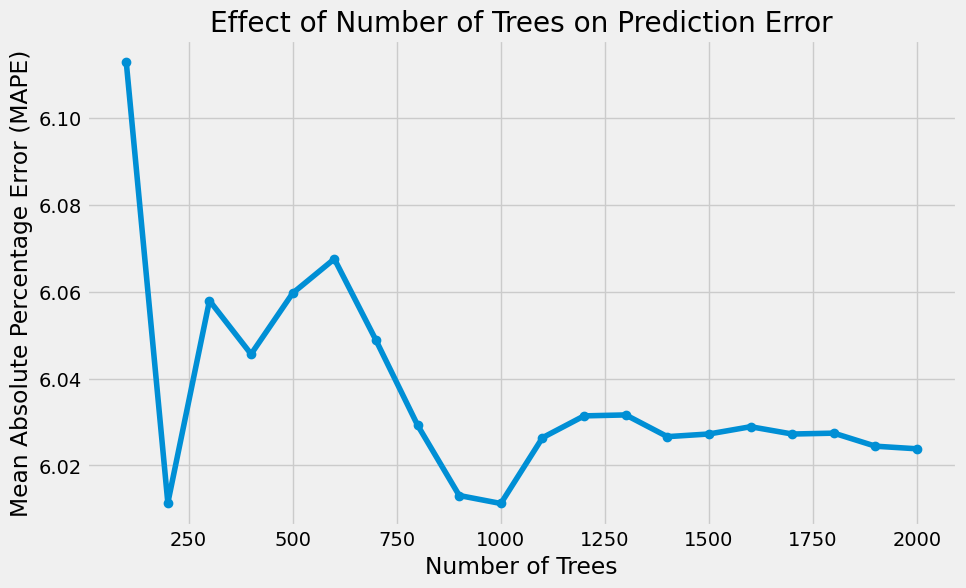

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 假设已经有 features 和 labels 数据集
# features = ...
# labels = ...

# 将数据集拆分为训练集和测试集
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state=42)

# 初始化参数
n_trees = range(100, 2001, 100)
trees_errors = []

# 遍历不同数量的树
for n in n_trees:
    # 建模
    rf = RandomForestRegressor(n_estimators=n, random_state=42)
    # 训练
    rf.fit(train_features, train_labels)
    # 预测结果
    predictions = rf.predict(test_features)
    # 计算误差
    abs_errors = abs(predictions - test_labels)
    # 使用MAPE计算误差相对值的一个比例
    tree_mape = 100 * (abs_errors / test_labels)
    # 记录误差
    trees_errors.append(np.mean(tree_mape))

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(n_trees, trees_errors, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Absolute Percentage Error (MAPE)')
plt.title('Effect of Number of Trees on Prediction Error')
plt.grid(True)
plt.show()

查看树部分 

Inspect part of the trees

In [14]:
# 导入所需工具包
# Import necessary libraries
from sklearn.tree import export_graphviz
import pydot

# 拿到随机森林里的其中的一棵树
# Extract one tree from the random forest
tree = rf.estimators_[5]

# 导出成dot文件
# Export the tree as a .dot file for visualization
export_graphviz(tree, out_file='tree.dot', feature_names=feature_list, rounded=True, precision=1)

# 绘图
# Create a graph from the .dot file
(graph,) = pydot.graph_from_dot_file('tree.dot')

# 图片写到一个目录里面
# Save the graph as a PNG image
graph.write_png('tree.png')

# 限制一下树模型
# Create a smaller random forest model with 10 trees and a max depth of 3
rf_small = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)
rf_small.fit(train_features, train_labels)

# 提取一颗树
# Extract one tree from the smaller random forest
tree_small = rf_small.estimators_[5]

# 保存
# Export the smaller tree as a .dot file
export_graphviz(tree_small, out_file='small_tree.dot', feature_names=feature_list, rounded=True, precision=1)

# 从dot文件中生成图像
# Create a graph from the smaller .dot file
(graph,) = pydot.graph_from_dot_file('small_tree.dot')

# 保存为PNG格式图像
# Save the smaller tree as a PNG image
graph.write_png('small_tree.png')

## 获取特征的重要性 Obtain feature importance

In [15]:
# 得到特征重要性
# Get the feature importances
importances = list(rf.feature_importances_)

# 转换格式
# Convert the feature importances into a list of tuples (feature, importance), rounded to 2 decimal places
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# 排序
# Sort the features by their importance in descending order
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# 对应进行打印
# Print the feature importances in a formatted way
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

Variable: temp_1               Importance: 0.69
Variable: average              Importance: 0.2
Variable: day                  Importance: 0.02
Variable: temp_2               Importance: 0.02
Variable: friend               Importance: 0.02
Variable: month                Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


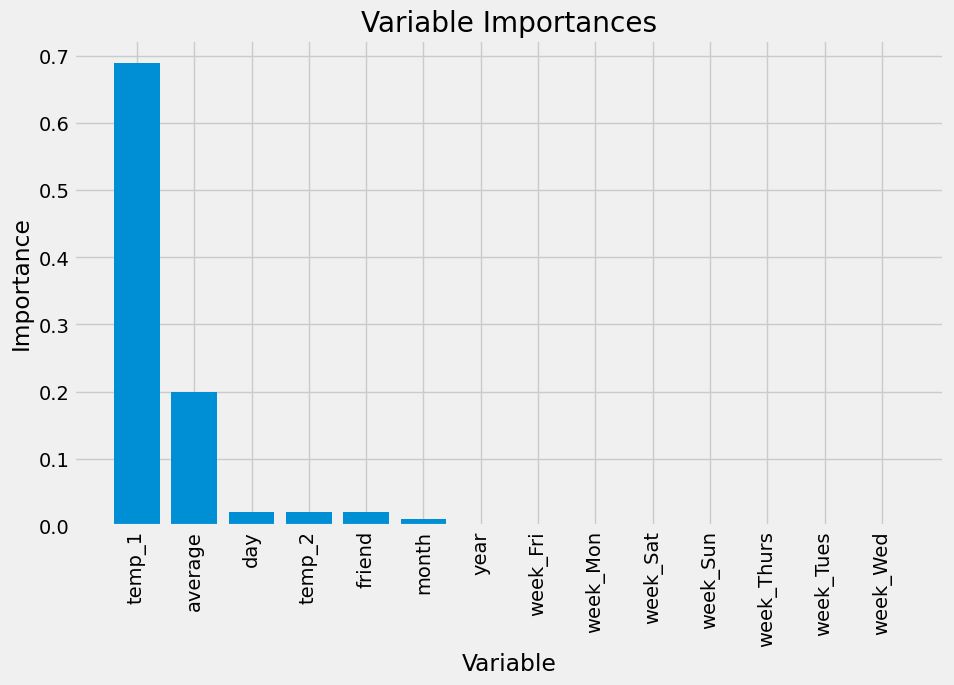

In [16]:
# 画个图更直观看这个几个特征的重要性
# Plot the feature importances for a more intuitive visualization

# 分离特征和重要性
# Separate the features and their corresponding importances
sorted_features = [item[0] for item in feature_importances]
sorted_importances = [item[1] for item in feature_importances]

# 转换成list格式
# Convert the features into a list of x-axis values
x_values = list(range(len(sorted_features)))

# 绘图
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x_values, sorted_importances, orientation='vertical')

# x轴名字
# Set the feature names on the x-axis, rotating them vertically
plt.xticks(x_values, sorted_features, rotation='vertical')

# 图名
# Set the labels and title for the plot
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')

# 显示图形
# Display the plot
plt.show()

In [25]:
# 选择最重要的那两个特征来试一试
# Select the two most important features for a test
rf_most_important = RandomForestRegressor(n_estimators=1000, random_state=42)

# 拿到这俩特征
# Get the indices of the two most important features ('temp_1' and 'average')
important_indices = [feature_list.index('temp_1'), feature_list.index('average')]

# 只保留最重要的特征
# Extract only the most important features from the training and test sets
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# 重新训练模型
# Train the random forest model on the most important features
rf_most_important.fit(train_important, train_labels)

# 预测结果
# Make predictions using the model trained on the most important features
mi_predictions = rf_most_important.predict(test_important)

# 计算预测误差
# Calculate the absolute errors
mi_errors = abs(mi_predictions - test_labels)

# 评估结果
# Evaluate the results by calculating the MAPE (Mean Absolute Percentage Error)
mi_mape = np.mean(100 * (mi_errors / test_labels))

# 打印结果
# Print the comparison between the full model and the reduced feature model
print('MAPE with all features:', mape)
print('MAPE with only most important features (mi_mape):', mi_mape)
print('Difference in error (mi_mape - mape):', mi_mape - mape)

MAPE with all features: 6.011244187972058
MAPE with only most important features (mi_mape): 6.229055723613811
Difference in error (mi_mape - mape): 0.21781153564175337


## 图对比真实数据 Compare with real data by image

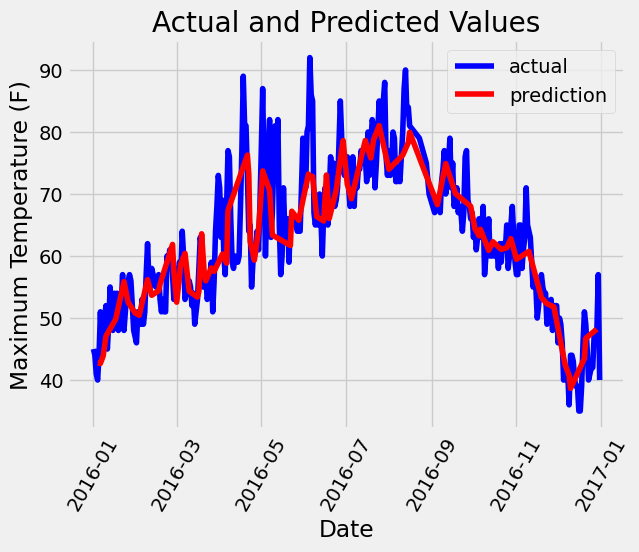

In [26]:
import matplotlib.pyplot as plt
import datetime
import pandas as pd

# 使用随机森林预测值
# 建模
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)
# 训练
rf.fit(train_features, train_labels)
# 预测结果
predictions = rf.predict(test_features)


# 画图对比预测值和真实值
# 日期数据
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
true_data = pd.DataFrame(data={'date': dates, 'actual': labels})

# 同理，再创建一个来存日期和其对应的模型预测值
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
predictions_data = pd.DataFrame(data={'date': test_dates, 'prediction': predictions})

# 两组数据按日期进行排序
true_data = true_data.sort_values('date')
predictions_data = predictions_data.sort_values('date')

# 真实值
plt.plot(true_data['date'], true_data['actual'], 'b-', label='actual')
# 预测值
plt.plot(predictions_data['date'], predictions_data['prediction'], 'r-', label='prediction')

# 显示图表
plt.xticks(rotation=60)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Maximum Temperature (F)')
plt.title('Actual and Predicted Values')
plt.show()

## 加入更多特征数据 Incoporate more data

In [44]:
# 导入工具包
# Import necessary libraries
import pandas as pd

# 读取数据
# Load the dataset from a CSV file
features = pd.read_csv('data/temps_extended.csv')

# 显示前5行数据
# Display the first 5 rows of the dataset
features.head(5)

,year,month,day,weekday,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,actual,friend
0,2011,1,1,Sat,4.92,0.00,0,36,37,45.6,40,40
1,2011,1,2,Sun,5.37,0.00,0,37,40,45.7,39,50
2,2011,1,3,Mon,6.26,0.00,0,40,39,45.8,42,42
3,2011,1,4,Tues,5.59,0.00,0,39,42,45.9,38,59
4,2011,1,5,Wed,3.80,0.03,0,42,38,46.0,45,39


In [39]:
features.shape

(2191, 12)

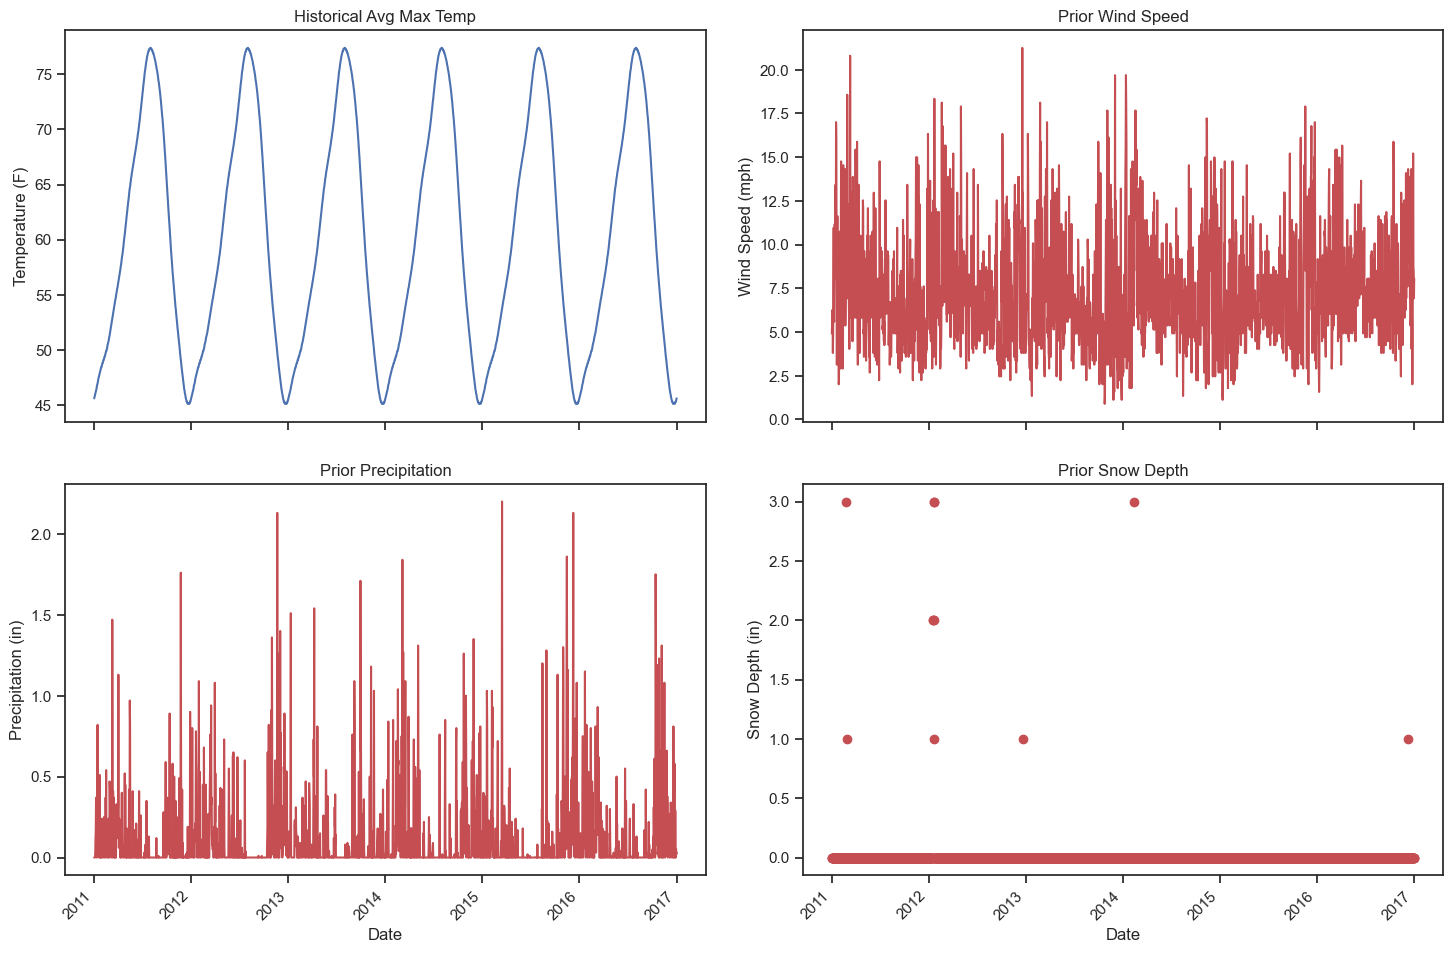

In [40]:
# 转换成标准格式
# Convert the date columns into standard datetime format
import datetime

# 得到各种日期数据
# Extract the year, month, and day columns
years = features['year']
months = features['month']
days = features['day']

# 格式转换
# Convert the extracted date components into a list of datetime objects
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) 
         for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# 设置整体布局
# Set up the layout for the subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
# Automatically format the x-axis date labels with a 45-degree rotation
fig.autofmt_xdate(rotation=45)

# 平均最高气温
# Plot historical average maximum temperature
ax1.plot(dates, features['average'])
ax1.set_xlabel('')  # No label for x-axis
ax1.set_ylabel('Temperature (F)')
ax1.set_title('Historical Avg Max Temp')

# 风速
# Plot prior wind speed
ax2.plot(dates, features['ws_1'], 'r-')
ax2.set_xlabel('')  # No label for x-axis
ax2.set_ylabel('Wind Speed (mph)')
ax2.set_title('Prior Wind Speed')

# 降水
# Plot prior precipitation
ax3.plot(dates, features['prcp_1'], 'r-')
ax3.set_xlabel('Date')
ax3.set_ylabel('Precipitation (in)')
ax3.set_title('Prior Precipitation')

# 积雪
# Plot prior snow depth
ax4.plot(dates, features['snwd_1'], 'ro')
ax4.set_xlabel('Date')
ax4.set_ylabel('Snow Depth (in)')
ax4.set_title('Prior Snow Depth')

# 自动调整子图间距
# Automatically adjust the spacing between subplots
plt.tight_layout(pad=2)

## 创建“季节”特征  Create a "Season" feature

In [41]:
import warnings
warnings.filterwarnings("ignore")

# 创建一个季节变量
# Create a new variable for seasons
seasons = []

# 根据月份确定季节（冬季、春季、夏季、秋季）
# Determine the season based on the month (winter, spring, summer, fall)
for month in features['month']:
    if month in [1, 2, 12]:
        seasons.append('winter')
    elif month in [3, 4, 5]:
        seasons.append('spring')
    elif month in [6, 7, 8]:
        seasons.append('summer')
    elif month in [9, 10, 11]:
        seasons.append('fall')

# 有了季节我们就可以分析更多东西了
# Now that we have the seasons, we can analyze more data
reduced_features = features[['temp_1', 'prcp_1', 'average', 'actual']]

# 将季节信息加入到数据集中
# Add the season information to the reduced features dataset
reduced_features['season'] = seasons

# 打印新的数据集
# Print the new dataset with the season column
print(reduced_features)

      temp_1  prcp_1  average  actual  season
0         37    0.00     45.6      40  winter
1         40    0.00     45.7      39  winter
2         39    0.00     45.8      42  winter
3         42    0.00     45.9      38  winter
4         38    0.03     46.0      45  winter
...      ...     ...      ...     ...     ...
2186      44    0.05     45.3      47  winter
2187      47    0.00     45.3      48  winter
2188      48    0.05     45.4      45  winter
2189      45    0.02     45.5      38  winter
2190      38    0.03     45.6      37  winter

[2191 rows x 5 columns]


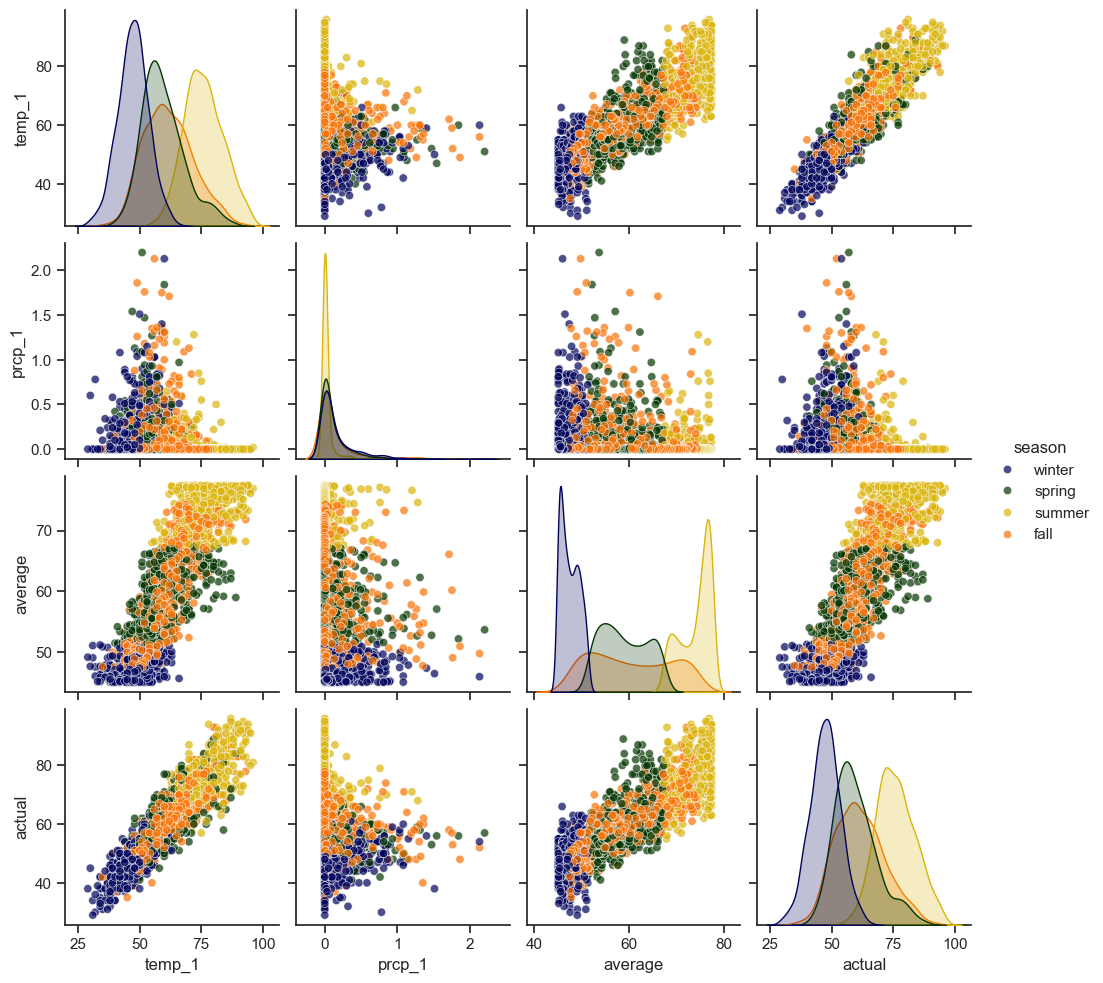

In [32]:
# 导入seaborn工具包
# Import the seaborn library for data visualization
import seaborn as sns

# 设置样式
# Set the default style and enable color codes
sns.set(style="ticks", color_codes=True)

# 选择你喜欢的颜色模板
# Choose a color palette for the plot
palette = sns.xkcd_palette(['dark blue', 'dark green', 'gold', 'orange'])

# 绘制pairplot
# Create a pairplot with KDE (kernel density estimate) on the diagonal
sns.pairplot(reduced_features, hue='season', diag_kind='kde', palette=palette, 
             plot_kws=dict(alpha=0.7), diag_kws=dict(shade=True))

## 验证新数据效果 Re-validate performance of adding new data

In [1]:
# 工具包导入
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf_exp = RandomForestRegressor(n_estimators= 100, random_state=0)

# 读取新数据
# Load the new dataset
features = pd.read_csv('data/temps_extended.csv')

# 将分类变量进行独热编码
# Perform one-hot encoding on categorical variables
features = pd.get_dummies(features)

# 将标签提取出来
# Extract the labels (target variable)
labels = features['actual']

# 删除标签列
# Drop the 'actual' column from features
features = features.drop('actual', axis=1)

# 保存特征名称
# Save the feature names
feature_list = list(features.columns)

# 将特征和标签转换为NumPy数组
# Convert features and labels to NumPy arrays
features = np.array(features)
labels = np.array(labels)

# 为了剔除特征个数对结果的影响，这里特征只保留有老数据里有的特征
# To ensure feature consistency between datasets, keep only the features present in the original dataset
original_feature_indices = [feature_list.index(feature)
                            for feature in feature_list 
                            if feature not in ['ws_1', 'prcp_1', 'snwd_1']]

# 读取老数据集
# Load the original dataset
original_features = pd.read_csv('data/temps.csv')

# 将分类变量进行独热编码
# Perform one-hot encoding on categorical variables
original_features = pd.get_dummies(original_features)

# 提取老数据集的标签
# Extract labels from the original dataset
original_labels = np.array(original_features['actual'])

# 删除标签列
# Drop the 'actual' column from the original features
original_features = original_features.drop('actual', axis=1)

# 保存原始特征名称
# Save the original feature names
original_feature_list = list(original_features.columns)

# 将老数据集的特征转换为NumPy数组
# Convert original features to NumPy array
original_features = np.array(original_features)

# 新数据集切分
# Split the new dataset into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.25, random_state=0)

# 老数据集切分
# Split the original dataset into training and testing sets
original_train_features, original_test_features, original_train_labels, original_test_labels = train_test_split(
    original_features, original_labels, test_size=0.25, random_state=42)

### 老数据 old data

In [2]:
# 同样的树模型进行建模
# Train the RandomForest model with the original dataset using the same parameters and random seed

# 使用老数据训练模型
# Train the model using the original training data
print("Training data size (original dataset):", original_train_features.shape)
rf.fit(original_train_features, original_train_labels)

# 使用新数据集做模型测试
# Test the model on the new dataset using only the original features
predictions = rf.predict(test_features[:, original_feature_indices])

# 先计算温度平均误差
# First, calculate the mean absolute error in temperature
errors = abs(predictions - test_labels)
print('Mean absolute error in temperature:', round(np.mean(errors), 2), 'degrees.')

# 计算MAPE（平均绝对百分比误差）
# Calculate MAPE (Mean Absolute Percentage Error)
mape = 100 * (errors / test_labels)

# 准确率计算：这里为了方便观察，我们就用100减去误差了，值越大越好
# Accuracy is calculated as 100 minus the mean MAPE. The higher, the better.
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Training data size (original dataset): (261, 14)
Mean absolute error in temperature: 4.67 degrees.
Accuracy: 92.2 %.


### 新数据 new data

In [5]:
# 剔除掉新的特征，保证数据特征是一致的，只是比老数据量更多而已
# Remove the new features to ensure feature consistency, but with more data points
new_train_features = train_features[:, original_feature_indices]
new_test_features = test_features[:, original_feature_indices]

# 使用新数据（去掉了新特征，只增加了数据量）训练模型
# Train the model using the new data (without new features, only increased data size)
print("Training data size (new data, no new features):", new_train_features.shape)
rf_exp.fit(new_train_features, train_labels)

# 使用新数据集做模型测试
# Test the model on the new test data
baseline_predictions = rf.predict(new_test_features)

# 计算误差
# Calculate the errors
baseline_errors = abs(baseline_predictions - test_labels)
print('Mean absolute error in temperature:', round(np.mean(baseline_errors), 2), 'degrees.')

# 计算MAPE（平均绝对百分比误差）
# Calculate MAPE (Mean Absolute Percentage Error)
baseline_mape = 100 * np.mean((baseline_errors / test_labels))

# 计算准确率
# Calculate accuracy (100% - MAPE)
baseline_accuracy = 100 - baseline_mape
print('Accuracy:', round(baseline_accuracy, 2), '%.')

Training data size (new data, no new features): (1643, 14)
Mean absolute error in temperature: 4.2 degrees.
Accuracy: 93.12 %.


## 抽取特征重要性 Extract Feature Importance

Variable: prcp_1               Importance: 0.85
Variable: snwd_1               Importance: 0.06
Variable: day                  Importance: 0.02
Variable: ws_1                 Importance: 0.02
Variable: temp_2               Importance: 0.02
Variable: year                 Importance: 0.01
Variable: month                Importance: 0.01
Variable: temp_1               Importance: 0.0
Variable: average              Importance: 0.0
Variable: friend               Importance: 0.0
Variable: weekday_Fri          Importance: 0.0
Variable: weekday_Mon          Importance: 0.0
Variable: weekday_Sat          Importance: 0.0
Variable: weekday_Sun          Importance: 0.0


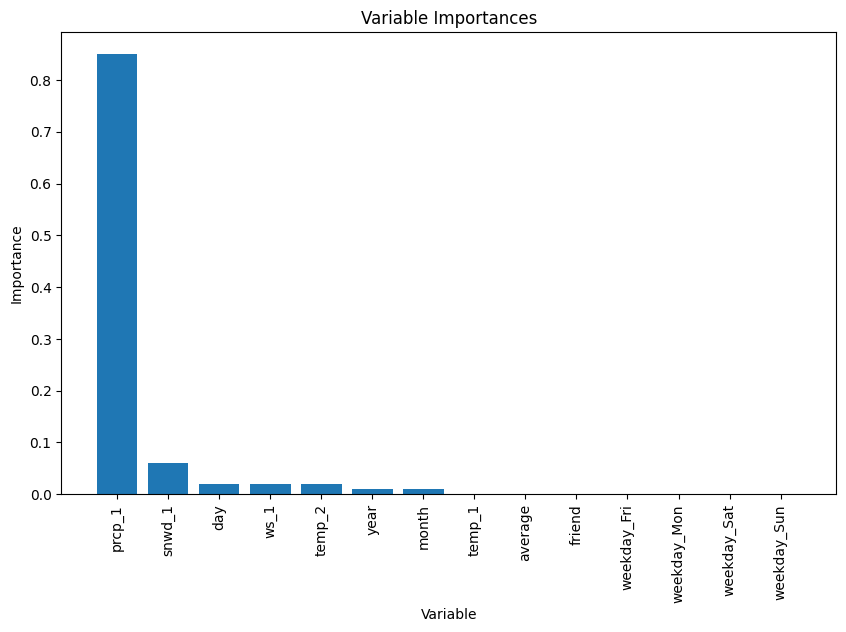

In [7]:
import matplotlib.pyplot as plt

# 得到特征重要性
# Get the feature importances from the trained random forest model
importances = list(rf_exp.feature_importances_)

# 转换格式
# Convert the importances into a list of tuples (feature, importance), rounded to 2 decimal places
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# 排序
# Sort the features by their importance in descending order
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# 对应进行打印
# Print the feature importances in a formatted way
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

# 画个图更直观看这个几个特征的重要性
# Plot the feature importances for a more intuitive visualization

# 分离特征和重要性
# Separate the features and their corresponding importances
sorted_features = [item[0] for item in feature_importances]
sorted_importances = [item[1] for item in feature_importances]

# 转换成list格式
# Convert the features into a list of x-axis values
x_values = list(range(len(sorted_features)))

# 绘图
# Create the bar plot for feature importances
plt.figure(figsize=(10, 6))
plt.bar(x_values, sorted_importances, orientation='vertical')

# 设置x轴标签
# Set the feature names on the x-axis, rotating them vertically for readability
plt.xticks(x_values, sorted_features, rotation='vertical')

# 图名与轴标签
# Set the labels for the axes and the title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')

# 显示图形
# Display the plot
plt.show()

## 降维建模 modeling with dimensionality reduction

In [8]:
# 选择这些特征
# Select the top 5 important features based on feature importances
important_feature_names = [feature[0] for feature in feature_importances[0:5]]

# 找到它们的名字
# Find the indices of these important features in the original feature list
important_indices = [feature_list.index(feature) for feature in important_feature_names]

# 重新创建训练集
# Create new training and testing sets using only the important features
important_train_features = train_features[:, important_indices]
important_test_features = test_features[:, important_indices]

# 数据维度
# Print the shape (dimensions) of the new training and testing sets
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

# 再训练模型
# Train the random forest model on the new training set with important features
print("Training data size (important features):", important_train_features.shape)
rf_exp.fit(important_train_features, train_labels)

# 同样的测试集
# Make predictions on the test set using the important features
predictions = rf_exp.predict(important_test_features)

# 评估结果
# Evaluate the results by calculating the absolute errors
errors = abs(predictions - test_labels)

# 打印平均温度误差
# Print the mean absolute error in temperature
print('Mean absolute error in temperature:', round(np.mean(errors), 2), 'degrees.')

# 计算MAPE（平均绝对百分比误差）
# Calculate MAPE (Mean Absolute Percentage Error)
mape = 100 * (errors / test_labels)

# 计算准确率
# Calculate accuracy (100% - MAPE)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Important train features shape: (1643, 5)
Important test features shape: (548, 5)
Training data size (important features): (1643, 5)
Mean absolute error in temperature: 5.39 degrees.
Accuracy: 91.18 %.
